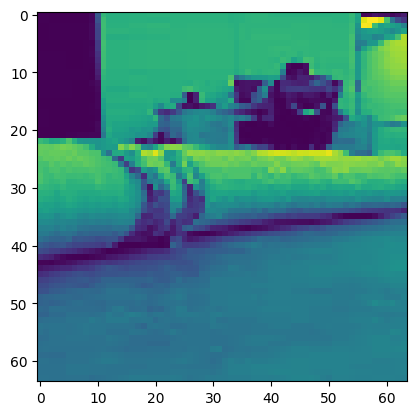

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def parse_file(dir: str, image_size=(64, 64)) -> tuple[np.ndarray, np.ndarray]:
    """
    Load grayscale video frames and labels from a CSV.

    Args:
        dir (str): Directory containing a video file and a CSV file with 'wheel' column.
        image_size (tuple): Resize frames to (width, height).

    Returns:
        Tuple:
            - frames: np.ndarray of shape (N, 1, H, W), dtype=np.uint8
            - labels: np.ndarray of shape (N,), dtype=np.int8
    """
    # Find video and CSV file
    video_file = next((f for f in os.listdir(dir) if f.lower().endswith(('.mp4', '.avi', '.mov'))), None)
    csv_file   = next((f for f in os.listdir(dir) if f.lower().endswith('.csv')), None)

    if not video_file or not csv_file:
        raise FileNotFoundError("Video or CSV file not found in the directory.")

    video_path = os.path.join(dir, video_file)
    csv_path   = os.path.join(dir, csv_file)

    # Read grayscale video frames
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Image translation to match Micro's camera
        img = cv2.resize(gray, (320,240))

        img = cv2.flip(img, 1)
        img = img[0:210,60:190]

        #img = img[0:210, 52:198]

        resized = cv2.resize(img, image_size)
        frames.append(resized[np.newaxis, ...])  # shape (1, H, W)
    cap.release()

    # Load and map CSV
    df = pd.read_csv(csv_path)
    if 'wheel' not in df.columns:
        raise ValueError("CSV must contain a 'wheel' column.")

    labels = df['wheel'].values

    # Align lengths
    min_len = min(len(frames), len(labels))
    frames = np.array(frames[:min_len], dtype=np.uint8)  # shape (N, 1, H, W)
    labels = labels[:min_len]

    return frames, labels

frames, labels = parse_file('../deeppicar/epoch0', (64, 64))

plt.imshow(np.squeeze(frames[0,...]))
plt.show()